# test area

In [1]:
from pathlib import Path
import os, sys
import seaborn as sb
import pandas as pd
from datetime import datetime

from pandas_plots import tbl, pls, ven , hlp
# from pandas_plots.hlp import OperatingSystem
from connection_helper import sql
import duckdb as ddb

hlp.show_package_version(["matplotlib_venn", "dataframe_image", "plotly", "kaleido", "seaborn"], )
df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'
# os.environ['RENDERER'] = "png"

dir_db=Path("C://temp") if hlp.get_os(hlp.OperatingSystem.WINDOWS) else Path(os.path.expanduser("~/tmp"))

file_db_clin = dir_db/'2025-06-24_data_clin.duckdb'
if not file_db_clin.is_file():
    print(f"File does not exist: {file_db_clin}")
    raise FileNotFoundError

print(hlp.get_os(hlp.OperatingSystem.MAC))

🐍 3.12.9 | 📦 matplotlib_venn: 0.11.10 | 📦 dataframe_image: 0.2.7 | 📦 plotly: 6.2.0 | 📦 kaleido: 1.0.0 | 📦 seaborn: 0.13.2 | 📦 pandas: 2.3.1 | 📦 numpy: 1.26.4 | 📦 duckdb: 1.3.2 | 📦 pandas-plots: 0.13.0 | 📦 connection-helper: 0.12
True


In [2]:
con = ddb.connect(file_db_clin, read_only=True)

In [3]:
db_delay = con.sql(f"""--sql
    select 
            first(z_kkr_label) as z_kkr_label,
            first(z_first_treatment_after_days) as z_first_treatment_after_days, 
            first(z_first_treatment) as z_first_treatment
    from Tumor
    where ifnull(z_first_treatment,'') <> ''
    and z_dy = 2023 and z_icd10_3d = 'C81'
    group by z_tum_id
    """)
tbl.descr_db(db_delay, caption="delay",)

🗄️ delay	1_688, 3
	("z_kkr_label, z_first_treatment_after_days, z_first_treatment")
┌─────────────┬──────────────────────────────┬───────────────────┐
│ z_kkr_label │ z_first_treatment_after_days │ z_first_treatment │
│   varchar   │            int32             │      varchar      │
├─────────────┼──────────────────────────────┼───────────────────┤
│ 05-NW       │                           27 │ sy                │
│ 08-BW       │                            0 │ op                │
│ 06-HE       │                           23 │ sy                │
└─────────────┴──────────────────────────────┴───────────────────┘



🔵 *** df: taxis ***  
🟣 shape: (6_433, 14) columns: ['pickup' 'dropoff' 'passengers' 'distance' 'fare' 'tip' 'tolls' 'total'
 'color' 'payment' 'pickup_zone' 'dropoff_zone' 'pickup_borough'
 'dropoff_borough']  
🟣 duplicates: 0  
🟣 uniques: [{pickup: 6_414 dropoff: 6_425 passengers: 7 distance: 1_079 fare: 220 tip: 489 tolls:  
16 total: 898 color: 2 payment: 2 pickup_zone: 194 dropoff_zone: 203 pickup_borough:  
4 dropoff_borough: 5}]  
🟣 missings: [{pickup: 0 dropoff: 0 passengers: 0 distance: 0 fare: 0 tip: 0 tolls: 0 total: 0 color:  
0 payment: 44 pickup_zone: 26 dropoff_zone: 45 pickup_borough: 26 dropoff_borough:  
45}]  
--- column stats (numeric)  
passengers -> min: 0 | lower: 0 | q25: 1.0 | median: 1.0 | mean: 1.539 | q75: 2.0 | upper: 3.5 | max: 6 | std: 1.204 | cv: 0.782 | sum: 9_902 | skew: 2.359 | kurto: 4.881  
distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | ske

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


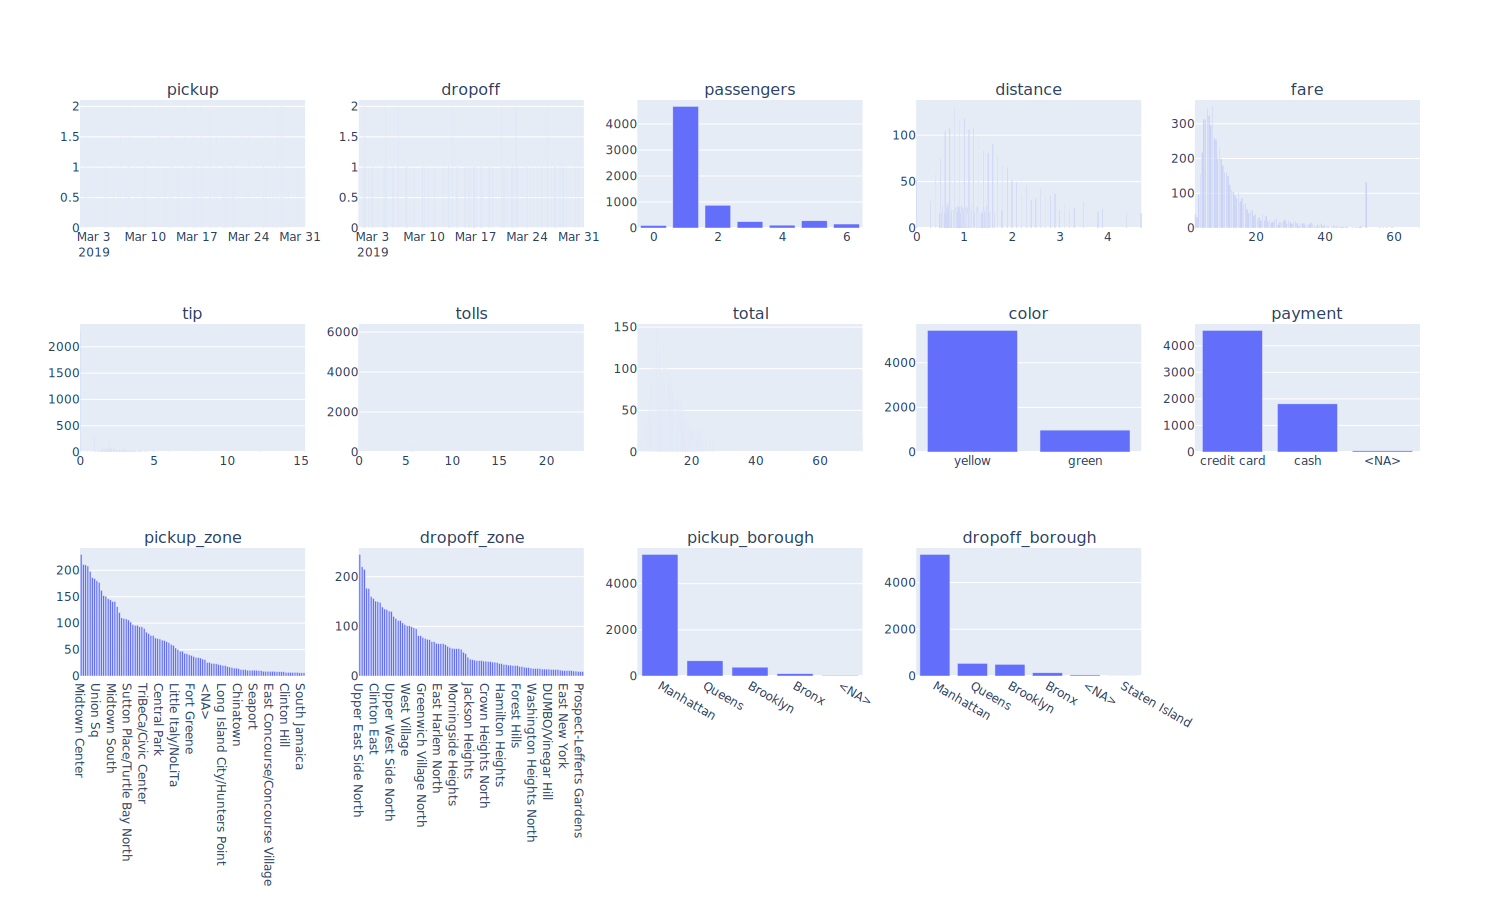

In [4]:
tbl.describe_df(
    df,
    "taxis",
    use_columns=False,
    renderer="svg",
)

In [5]:
lol=db_delay.to_df().iloc[:,:1].to_series()
pls.plot_bars(lol)

In [6]:
_=pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    # x_max=50,
    use_log=True,
    annotations=False,
    # summary = False,
    # png_path=Path("box1.png"),
)

distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135  


In [7]:
_ = pls.plot_boxes(
    # _df[["z_kkr_label", "z_first_treatment_after_days"]],
    db_delay.to_df().iloc[:,:2],
    height=500, width=2000,
    annotations=False,
    use_log=True,
    summary=True,    
)


🟧 all data
z_first_treatment_after_days -> min: 0 | lower: 0 | q25: 10.0 | median: 28.0 | mean: 39.3 | q75: 48.0 | upper: 105.0 | max: 609 | std: 53.28 | cv: 1.36 | sum: 64_931 | skew: 4.43 | kurto: 29.2  
🟧 boxes
01-SH -> min: 0 | lower: 0 | q25: 18.75 | median: 34.0 | mean: 53.01 | q75: 57.25 | upper: 115.0 | max: 304 | std: 60.41 | cv: 1.14 | sum: 3_605 | skew: 2.31 | kurto: 5.38  
02-HH -> min: 0 | lower: 0 | q25: 0.0 | median: 26.0 | mean: 33.9 | q75: 41.75 | upper: 104.38 | max: 251 | std: 46.31 | cv: 1.37 | sum: 1_695 | skew: 2.79 | kurto: 9.47  
03-NI -> min: 0 | lower: 0 | q25: 16.0 | median: 34.0 | mean: 39.65 | q75: 55.0 | upper: 113.5 | max: 237 | std: 33.43 | cv: 0.84 | sum: 6_066 | skew: 1.78 | kurto: 6.9  
04-HB -> min: 0 | lower: 0 | q25: 13.0 | median: 15.0 | mean: 77.89 | q75: 98.0 | upper: 225.5 | max: 257 | std: 98.94 | cv: 1.27 | sum: 701 | skew: 1.03 | kurto: -0.58  
05-NW -> min: 0 | lower: 0 | q25: 3.25 | median: 23.5 | mean: 36.9 | q75: 41.75 | upper: 99.5 | ma

In [8]:
db_delay.to_df().iloc[:,:2]

,z_kkr_label,z_first_treatment_after_days
0,08-BW,0
1,03-NI,13
2,14-SN,52
3,09-BY,71
4,16-TH,0
...,...,...
1683,05-NW,7
1684,12-BB,22
1685,06-HE,1
1686,11-BE,0


In [9]:
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    # height=400,
    # width=1000,
    # use_ci=True,
    # ci_agg='median',
)
_ = pls.plot_bars(
    db_delay.to_df().iloc[:,:2],
    height=600,
    use_ci=True,
    ci_agg='median',
)

In [10]:
db_delay.to_df().iloc[:,[0,2,1]].dropna()

,z_kkr_label,z_first_treatment,z_first_treatment_after_days
0,07-RP,sy,46
1,05-NW,sy,134
2,07-RP,sy,29
3,05-NW,op,4
4,08-BW,sy,45
...,...,...,...
1683,11-BE,sy,50
1684,02-HH,sy,28
1685,06-HE,sy,27
1686,05-NW,sy,29


In [11]:
pls.plot_stacked_bars(
    db_delay.to_df().iloc[:,[0,2,1]].dropna(),
    height=600,
    # width=1000,
    orientation="h",
    relative=True,
    show_pct_bar=True,
    # renderer="png",
    )

In [12]:
_df = df[["passengers", "distance", "fare"]][:1]
tbl.show_num_df(
    _df,
    total_axis="xy",
    total_mode="mean",
    data_bar_axis="xy",
    pct_axis="",
    precision=2,
    total_exclude=False,
    show_as_pct=True,
    col1_width=100,
    # swap=True,
    # kpi_mode="",
    # kpi_mode="max_min_x",
    # kpi_rag_list=(1,7),
)

,passengers,distance,fare,Total
0,100.00%,160.00%,700.00%,320.00%
Total,100.00%,160.00%,700.00%,320.00%


In [13]:
tbl.pivot_df(
    df,
    )

❌ df must have exactly 3 columns


In [14]:
pls.plot_sankey(
    width=2000,
    font_size=15,
    # renderer="png",
)

--- Using demo data (data_demo) ---
  tumor-id diagnosis date treatment
0        1     2020-01-01        op
1        1     2021-02-01      syst
2        1     2022-03-01        op
3        1     2023-04-01       rad
4        1     2024-05-01        op
-----------------------------------


In [15]:
df_facets = pd.read_csv("assets/facets.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_facets[:None])
print(df_facets.dtypes)

,z_dy,tu,z_kkr_label,cnt
0,2020,06,13-MV,1
1,2020,30,13-MV,1
2,2020,###,13-MV,21
3,2020,18,11-BE,1
4,2020,18.,13-MV,1
...,...,...,...,...
16352,2023,S37,14-SN,1
16353,2023,S72,11-BE,1
16354,2023,Z22,14-SN,1
16355,2023,Z85,14-SN,1


z_dy            int64
tu             object
z_kkr_label    object
cnt             int64
dtype: object


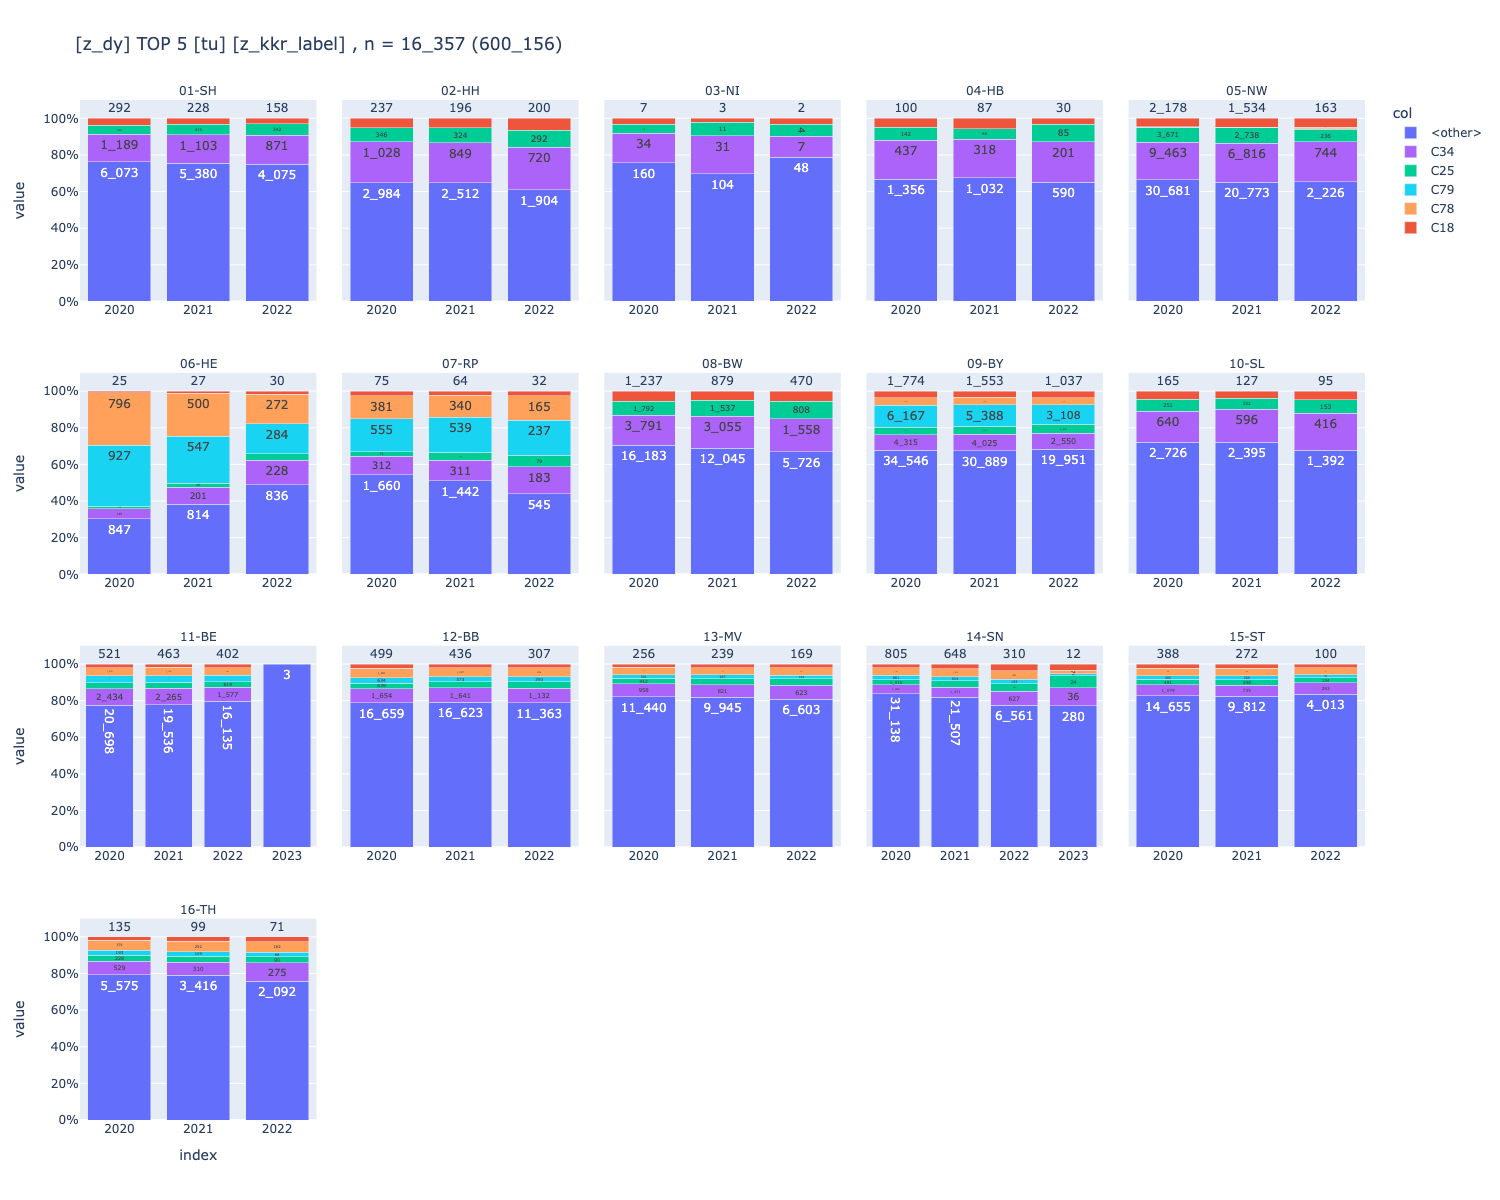

In [16]:
_df = df_facets[
    [
        "z_dy",
        "tu",
        "z_kkr_label",
        "cnt",
    ]
]#[:100]
# _df


l=pls.plot_facet_stacked_bars(
    _df,
    top_n_color=5,
    # subplots_per_row=3,
    # top_n_facet=15,
    # top_n_index=3, 
    show_other=True,
    sort_values_color=True,
    # sort_values_facet=True,
    relative=True,
    # show_pct=True,
    annotations=True,
    subplot_size=300,
    subplots_per_row=5,
    # renderer="",
    # show_pct=True,
    )
# l

# ll = pls.plot_facet_stacked_bars(
#     _df,
#     top_n_color=5,
#     # subplots_per_row=8,
#     # top_n_facet=15,
#     # top_n_index=3, 
#     show_other=True,
#     sort_values_color=True,
#     # sort_values_facet=True,
#     relative=True,
#     annotations=True,
#     )
# # ll

In [17]:
# con.close()
# sys.exit(1)

In [18]:
hlp.add_measures_to_pyg_config(".local/pygwalker_spec_.json", strict=False)

In [19]:
hlp.find_cols(df, [
    "tot",
    "dis",
    ])


['total', 'distance']

In [20]:
# sys.exit(1)

In [21]:
df_dsich = pd.read_csv("assets/dsich.csv", sep=";")#.astype({"z_dy": "Int64"}).astype({"z_dy": str})
display(df_dsich[:3])
# print(df_dsich.dtypes)

,id,bl,label,cnt
0,0,01-SH,7 - Histologie Primärtumor,14351
1,22,01-SH,3 - Todesbescheinigung (DCO),1004
2,23,01-SH,5 - Zytologie,146


In [22]:
_df = df_dsich[
    [
        "bl",
        "label",
        "cnt",
    ]
].sort_values("bl")

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    # height=1000,
    # top_n_color=5,
    # sort_values_index=True,
    sort_values_color=True,
    # top_n_index=3,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
)
_

In [23]:
_df = df_facets[
    [
        "z_kkr_label",
        "z_dy",
        "cnt",
    ]
]#.astype({"z_dy": str})

_ = pls.plot_stacked_bars(
    _df,
    # swap=True,
    orientation="h",
    # show_total=True,
    # normalize=True,
    # relative=True,
    height=1000,
    top_n_color=10,
    # sort_values_index=True,
    # sort_values_color=True,
    # top_n_index=5,
    # precision=2,
    # show_other=True,
    # top_n_index=2,
    # renderer="png",
)
_

In [24]:
_df = df_facets[
    [
        "z_kkr_label",
        "cnt",
    ]
]
_df

_ = pls.plot_bars(
    _df,
    height=600,
    width=1200,
    sort_values=True,
    # renderer="png",
)

In [25]:
_=pls.plot_box(
    df.distance,
    height=400,
    violin=True,
    x_min=-2,
    x_max=50,
    # summary = False,
    # png_path=Path("box1.png"),
    # renderer="svg",
)

distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135  


🔵 *** df: lol ***  
🟣 shape: (6_433, 14) columns: ['pickup' 'dropoff' 'passengers' 'distance' 'fare' 'tip' 'tolls' 'total'
 'color' 'payment' 'pickup_zone' 'dropoff_zone' 'pickup_borough'
 'dropoff_borough']  
🟣 duplicates: 0  
🟣 uniques: [{pickup: 6_414 dropoff: 6_425 passengers: 7 distance: 1_079 fare: 220 tip: 489 tolls:  
16 total: 898 color: 2 payment: 2 pickup_zone: 194 dropoff_zone: 203 pickup_borough:  
4 dropoff_borough: 5}]  
🟣 missings: [{pickup: 0 dropoff: 0 passengers: 0 distance: 0 fare: 0 tip: 0 tolls: 0 total: 0 color:  
0 payment: 44 pickup_zone: 26 dropoff_zone: 45 pickup_borough: 26 dropoff_borough:  
45}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4,]  
🟠 pickup(6_414|datetime64[ns])   [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53,  
2019-03-01 00:29:22,]  
🟠 dropoff(6_425|datetime64[ns])   [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48,  
2019-03-01 00:37:39,]  
🟠 passengers(7|int64) 

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


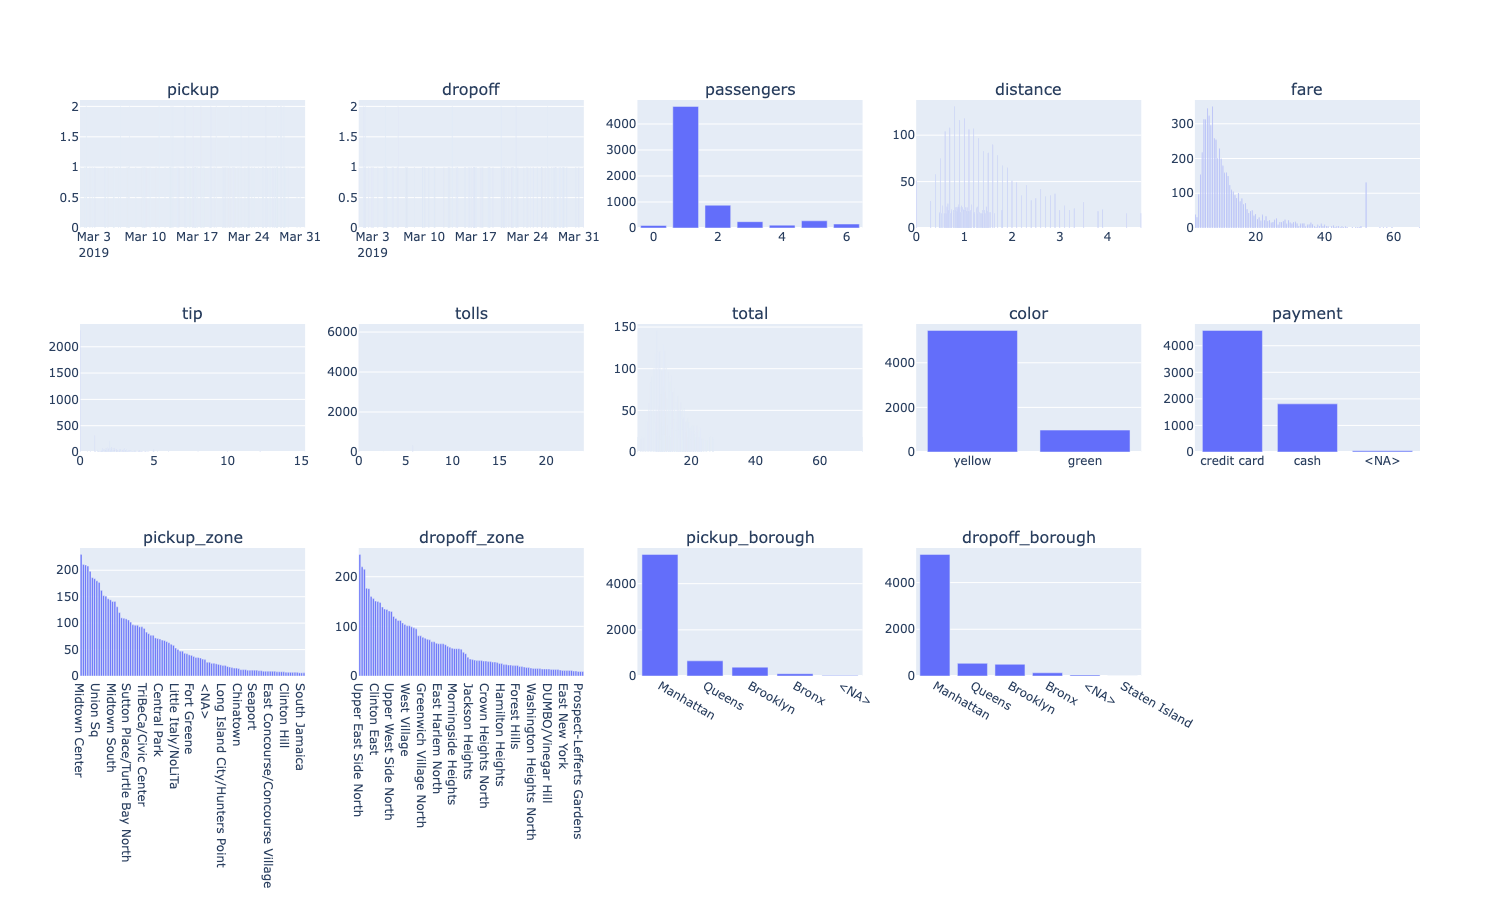

In [26]:
tbl.describe_df(df,"lol", renderer="png")

In [27]:
_df = df[["dropoff_borough", "distance"]]
# _df["dropoff_borough"] = _df["dropoff_borough"].astype(str)
display(_df.dtypes)
display(_df)
_=pls.plot_boxes(
    _df,
    width=1600,
    annotations=False,
    precision=4,
)

dropoff_borough     object
distance           float64
dtype: object

,dropoff_borough,distance
0,Manhattan,1.60
1,Manhattan,0.79
2,Manhattan,1.37
3,Manhattan,7.70
4,Manhattan,2.16
...,...,...
6428,Manhattan,0.75
6429,Bronx,18.74
6430,Brooklyn,4.14
6431,Brooklyn,1.12


🟧 all data
distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.0246 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.8279 | cv: 1.2656 | sum: 19_457.36 | skew: 3.0075 | kurto: 11.1349  
🟧 boxes
Bronx -> min: 0.0 | lower: 0.0 | q25: 2.36 | median: 4.31 | mean: 6.6123 | q75: 9.44 | upper: 20.06 | max: 24.2 | std: 5.9527 | cv: 0.9003 | sum: 905.88 | skew: 1.299 | kurto: 0.8808  
Brooklyn -> min: 0.0 | lower: 0.0 | q25: 1.53 | median: 3.63 | mean: 5.0285 | q75: 7.3 | upper: 15.955 | max: 26.92 | std: 4.4884 | cv: 0.8926 | sum: 2_519.28 | skew: 1.4211 | kurto: 2.2301  
Manhattan -> min: 0.0 | lower: 0.0 | q25: 0.91 | median: 1.5 | mean: 2.391 | q75: 2.6 | upper: 5.135 | max: 30.23 | std: 2.905 | cv: 1.215 | sum: 12_447.68 | skew: 3.7367 | kurto: 17.386  
Queens -> min: 0.0 | lower: 0.0 | q25: 1.335 | median: 3.56 | mean: 5.9596 | q75: 9.8875 | upper: 22.7162 | max: 36.7 | std: 5.8864 | cv: 0.9877 | sum: 3_230.13 | skew: 1.2906 | kurto: 1.4972  
Staten Island -> min: 15.51 

,color,dropoff_borough,payment
0,yellow,Manhattan,credit card
1,yellow,Manhattan,cash
2,yellow,Manhattan,credit card
3,yellow,Manhattan,credit card
4,yellow,Manhattan,credit card
...,...,...,...
6428,green,Manhattan,credit card
6429,green,Bronx,credit card
6430,green,Brooklyn,cash
6431,green,Brooklyn,credit card


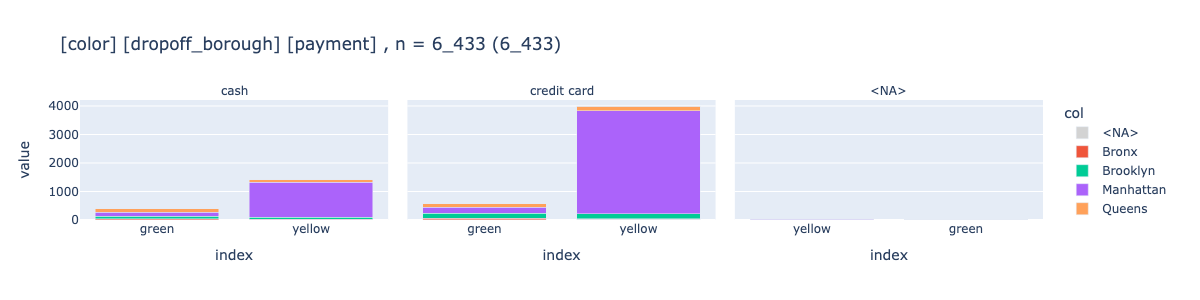

In [28]:

_df2 = df[
    [
        "color",
        "dropoff_borough", 
        "payment",
        # "total"
    ]]

display(_df2)

l=pls.plot_facet_stacked_bars(
    _df2, 
    # top_n_columns=2,
    # subplots_per_row=2,
    )

In [29]:
lol =tbl.print_summary(df, show=False)
lol#.get("lower")

❌ df must have 2 columns: [0] str or bool, [1] num, or be a series


In [30]:
_df = df[["color","payment","pickup_borough","total"]]
_df
# _=pls.plot_stacked_bars(_df[["color","payment","total"]],)
tbl.describe_df(_df, "taxis")

🔵 *** df: taxis ***  
🟣 shape: (6_433, 4) columns: ['color' 'payment' 'pickup_borough' 'total']  
🟣 duplicates: 4_803  
🟣 uniques: [{color: 2 payment: 2 pickup_borough: 4 total: 898}]  
🟣 missings: [{color: 0 payment: 44 pickup_borough: 26 total: 0}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4,]  
🟠 color(2|object)   ['green', 'yellow',]  
🟠 payment(3|object)   ['<NA>', 'cash', 'credit card',]  
🟠 pickup_borough(5|object)   ['<NA>', 'Bronx', 'Brooklyn', 'Manhattan', 'Queens',]  
🟠 total(898|float64)   [1.3, 3.3, 3.31, 3.8, 4.3,]  
--- column stats (numeric)  
total -> min: 1.3 | lower: 1.3 | q25: 10.8 | median: 14.16 | mean: 18.518 | q75: 20.3 | upper: 34.55 | max: 174.82 | std: 13.816 | cv: 0.746 | sum: 119_124.97 | skew: 3.093 | kurto: 15.053  


,color,payment,pickup_borough,total
0,yellow,credit card,Manhattan,12.95
1,yellow,cash,Manhattan,9.30
2,yellow,credit card,Manhattan,14.16


In [31]:
from pandas_plots.hlp import to_series

df.pickup.to_series()

0      2019-03-23 20:21:09
1      2019-03-04 16:11:55
2      2019-03-27 17:53:01
3      2019-03-10 01:23:59
4      2019-03-30 13:27:42
               ...        
6428   2019-03-31 09:51:53
6429   2019-03-31 17:38:00
6430   2019-03-23 22:55:18
6431   2019-03-04 10:09:25
6432   2019-03-13 19:31:22
Name: pickup, Length: 6433, dtype: datetime64[ns]

In [32]:
db = con.from_df(df)
tbl.descr_db(db, caption="taxis",)

🗄️ taxis	6_433, 14
	("pickup, dropoff, passengers, distance, fare, tip, tolls, total, color, payment, pickup_zone, dropoff_zone, pickup_borough, dropoff_borough")
┌─────────────────────┬─────────────────────┬────────────┬──────────┬────────┬────────┬────────┬────────┬─────────┬─────────────┬───────────────────────┬───────────────────────┬────────────────┬─────────────────┐
│       pickup        │       dropoff       │ passengers │ distance │  fare  │  tip   │ tolls  │ total  │  color  │   payment   │      pickup_zone      │     dropoff_zone      │ pickup_borough │ dropoff_borough │
│    timestamp_ns     │    timestamp_ns     │   int64    │  double  │ double │ double │ double │ double │ varchar │   varchar   │        varchar        │        varchar        │    varchar     │     varchar     │
├─────────────────────┼─────────────────────┼────────────┼──────────┼────────┼────────┼────────┼────────┼─────────┼─────────────┼───────────────────────┼───────────────────────┼────────────────┼────

In [33]:
_=tbl.print_summary(df)

❌ df must have 2 columns: [0] str or bool, [1] num, or be a series


🔵 *** df: test ***  
🟣 shape: (6_433, 14) columns: ['pickup' 'dropoff' 'passengers' 'distance' 'fare' 'tip' 'tolls' 'total'
 'color' 'payment' 'pickup_zone' 'dropoff_zone' 'pickup_borough'
 'dropoff_borough']  
🟣 duplicates: 0  
🟣 uniques: [{pickup: 6_414 dropoff: 6_425 passengers: 7 distance: 1_079 fare: 220 tip: 489 tolls:  
16 total: 898 color: 2 payment: 2 pickup_zone: 194 dropoff_zone: 203 pickup_borough:  
4 dropoff_borough: 5}]  
🟣 missings: [{pickup: 0 dropoff: 0 passengers: 0 distance: 0 fare: 0 tip: 0 tolls: 0 total: 0 color:  
0 payment: 44 pickup_zone: 26 dropoff_zone: 45 pickup_borough: 26 dropoff_borough:  
45}]  
--- column uniques (all)  
🟠 index [0, 1, 2, 3, 4,]  
🟠 pickup(6_414|datetime64[ns])   [2019-02-28 23:29:03, 2019-03-01 00:03:29, 2019-03-01 00:08:32, 2019-03-01 00:15:53,  
2019-03-01 00:29:22,]  
🟠 dropoff(6_425|datetime64[ns])   [2019-02-28 23:32:35, 2019-03-01 00:13:32, 2019-03-01 00:29:47, 2019-03-01 00:32:48,  
2019-03-01 00:37:39,]  
🟠 passengers(7|int64)

,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


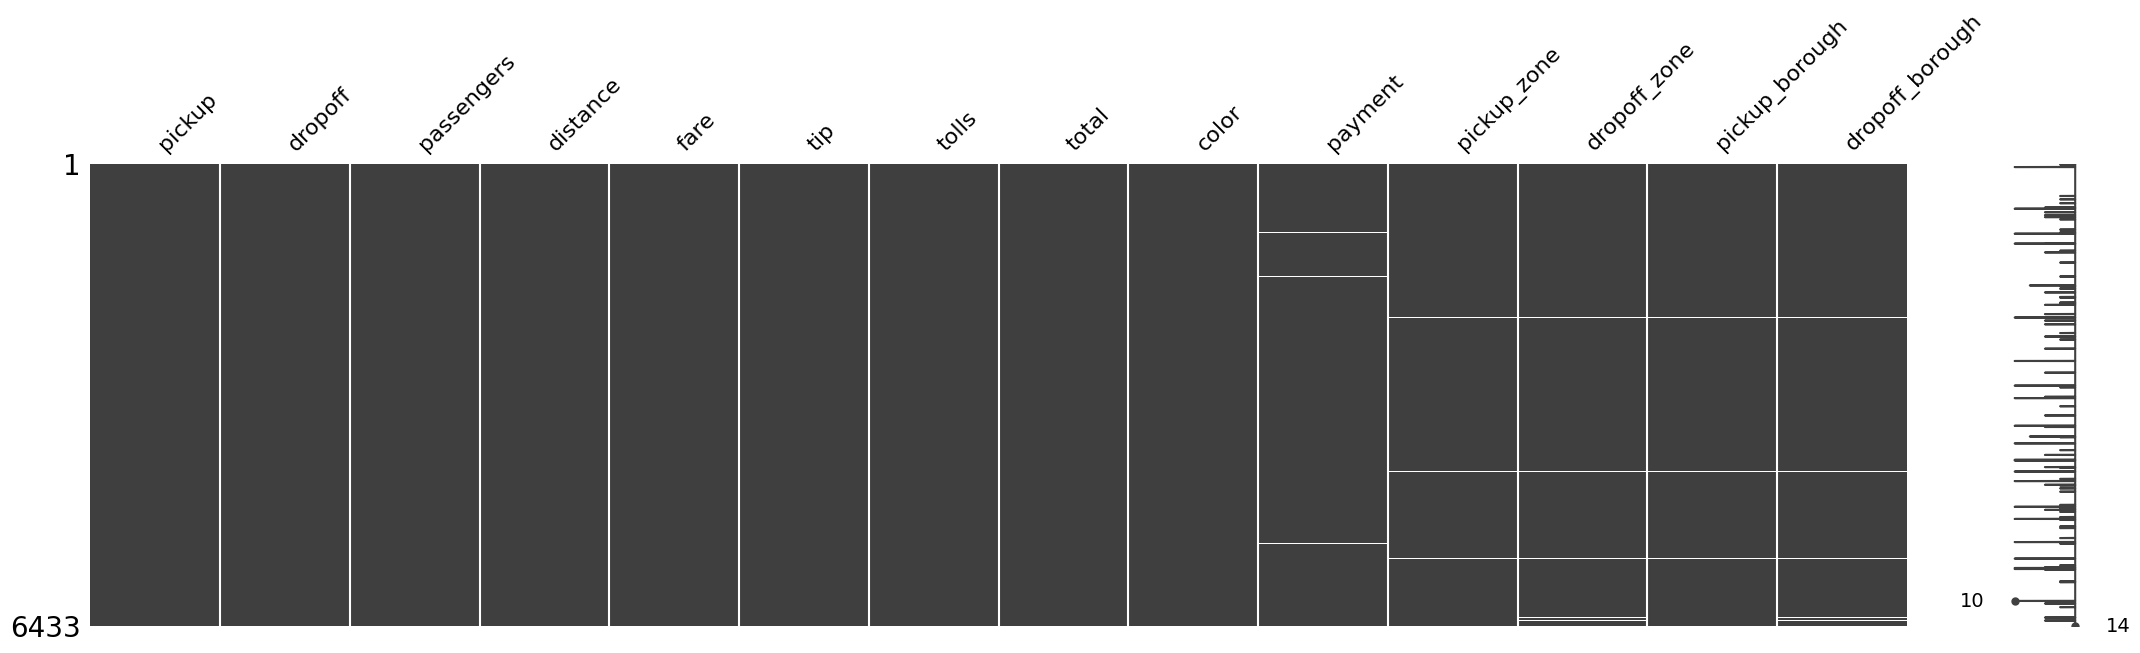

In [34]:
tbl.describe_df(
    df,
    "test",
    use_plot=True,
    use_columns=True,
    use_missing=True,
)

## show num

In [35]:
from pathlib import Path

_df=df.pivot_table(index="color", columns="payment", values="fare", aggfunc="sum", dropna=False)
tbl.show_num_df(
    _df,
    total_mode="sum",
    total_axis="y",
    data_bar_axis="",
    pct_axis="xy",
    precision=0,
    heatmap_axis="xy",
    # kpi_mode="max_min_x",
    total_exclude=True,
    # kpi_mode="min_max_xy",
    kpi_mode="rag_abs",
    kpi_rag_list=(100, 1000),
    # swap=True,
    font_size_td=12,
    font_size_th=14,
    # png_path=Path("test.png"),
)

payment,cash,credit card,nan,Total
color,,,,
green,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,20 (0.0%) 🟩,13_788 (16.4%) 🟥
yellow,17_012 (20.2%) 🟥,52_907 (62.8%) 🟥,508 (0.6%) 🟨,70_427 (83.6%) 🟥


In [36]:
_df=df[["color", "payment", "fare"]]
tbl.pivot_df(
    _df,
    total_mode="sum",
    data_bar_axis="xy",
    pct_axis="xy",
    precision=0,
    heatmap_axis="",
    kpi_mode="max_min_x"
    # kpi_mode="min_max_xy",
    # kpi_mode="rag_abs",
    # kpi_rag_list=(100, 1000),
)

payment,,cash,credit card,Total
color,,,,
green,20 (0.0%) 🟥,3_995 (4.7%) 🟥,9_774 (11.6%) 🟥,13_788 (16.4%) 🟥
yellow,508 (0.6%) 🟩,17_012 (20.2%) 🟩,52_907 (62.8%) 🟩,70_427 (83.6%) 🟩
Total,528 (0.6%) ⬜,21_006 (24.9%) ⬜,62_681 (74.4%) ⬜,84_215 (100.0%) ⬜


In [37]:
_df = df[["distance", "fare", "tip", "tolls"]][:5]
tbl.show_num_df(
    _df,
    data_bar_axis="x",
    pct_axis="xy",
    precision=3,
    total_mode="sum",
)
# _df['distance'].mean()

,distance,fare,tip,tolls,Total
0,1.600 (2.0%),7.000 (8.7%),2.150 (2.7%),0,10.750 (13.3%)
1,0.790 (1.0%),5.000 (6.2%),0,0,5.790 (7.2%)
2,1.370 (1.7%),7.500 (9.3%),2.360 (2.9%),0,11.230 (13.9%)
3,7.700 (9.5%),27.000 (33.4%),6.150 (7.6%),0,40.850 (50.5%)
4,2.160 (2.7%),9.000 (11.1%),1.100 (1.4%),0,12.260 (15.2%)
Total,13.620 (16.8%),55.500 (68.6%),11.760 (14.5%),0,80.880 (100.0%)


## venn

ab --> cars1 | cars2 --> len: 7


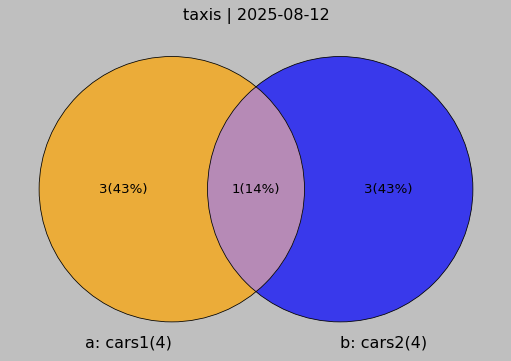

In [38]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
_df, _details = ven.show_venn2(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    verbose=0,
    size=8,
)

abc --> cars1 | cars2 | cars3 --> len: 11
ab --> cars1 | cars2 --> len: 7
ac --> cars1 | cars3 --> len: 8
bc --> cars2 | cars3 --> len: 9


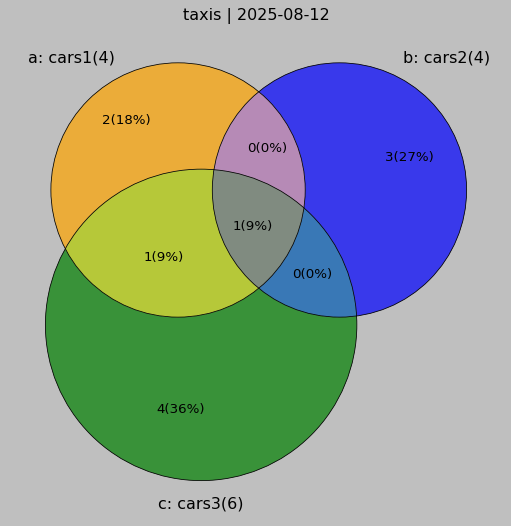

In [39]:
from pandas_plots import ven

set_a = {'ford','ferrari','mercedes', 'bmw'}
set_b = {'opel','bmw','bentley','audi'}
set_c = {'ferrari','bmw','chrysler','renault','peugeot','fiat'}
_df, _details = ven.show_venn3(
    title="taxis",
    a_set=set_a,
    a_label="cars1",
    b_set=set_b,
    b_label="cars2",
    c_set=set_c,
    c_label="cars3",
    verbose=0,
    size=8,
)

## stacked bars

## boxes

In [40]:
pls.plot_box(
    df.distance,
    height=400,
    violin=False,
    x_min=-2,
    x_max=50,
    # summary = False
)

distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.025 | q75: 3.21 | upper: 6.555 | max: 36.7 | std: 3.828 | cv: 1.266 | sum: 19_457.36 | skew: 3.008 | kurto: 11.135  


In [41]:
_df=df[['color','distance']]
_df['is_green']=_df['color'].apply(lambda x: x=='green')
pls.plot_boxes(_df[['is_green','distance']], height=700, png_path=Path(".local/box3.png"))
_df
# pd.api.types.is_bool_dtype(_df['is_green'])

🟧 all data
distance -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.64 | mean: 3.02 | q75: 3.21 | upper: 6.56 | max: 36.7 | std: 3.83 | cv: 1.27 | sum: 19_457.36 | skew: 3.01 | kurto: 11.13  
🟧 boxes
False -> min: 0.0 | lower: 0.0 | q25: 0.98 | median: 1.6 | mean: 2.96 | q75: 3.09 | upper: 6.26 | max: 36.7 | std: 3.77 | cv: 1.28 | sum: 16_111.41 | skew: 3.08 | kurto: 11.66  
True -> min: 0.0 | lower: 0.0 | q25: 1.01 | median: 1.84 | mean: 3.41 | q75: 3.94 | upper: 8.33 | max: 33.46 | std: 4.11 | cv: 1.2 | sum: 3_345.95 | skew: 2.68 | kurto: 8.86  


,color,distance,is_green
0,yellow,1.60,False
1,yellow,0.79,False
2,yellow,1.37,False
3,yellow,7.70,False
4,yellow,2.16,False
...,...,...,...
6428,green,0.75,True
6429,green,18.74,True
6430,green,4.14,True
6431,green,1.12,True


## bars

In [42]:
import os, sys
import seaborn as sb
import pandas as pd
from importlib.metadata import version
print(f'seaborn: {version("seaborn")}')
from matplotlib import pyplot as plt

from pandas_plots import tbl, pls, ven, hlp
# from pandas_plots.tbl import *

df = sb.load_dataset('taxis')
os.environ['THEME'] = 'light'
df[:3]

seaborn: 0.13.2


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,pickup_zone,dropoff_zone,pickup_borough,dropoff_borough
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,Lenox Hill West,UN/Turtle Bay South,Manhattan,Manhattan
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,Upper West Side South,Upper West Side South,Manhattan,Manhattan
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,Alphabet City,West Village,Manhattan,Manhattan


In [43]:
_df = df["distance"]
# _df#.to_frame()
# _df=df[["fare","distance"]]
pls.plot_histogram(
    _df,
    height=800,
    width=1600,
    precision=0,
    orientation="v",
    histnorm="",
    nbins=0,
    # barmode="overlay",
    # renderer="png",
    png_path=Path(".local/box5.png"),
)

In [44]:
# px.histogram(
#     # df[["fare","passengers"]],
#     df[["fare"]],
#     histnorm="",
#     nbins=0,
#     text_auto=True,
#     marginal="",
#     # barmode="",
#     height=500,
#     width=1200,
# )

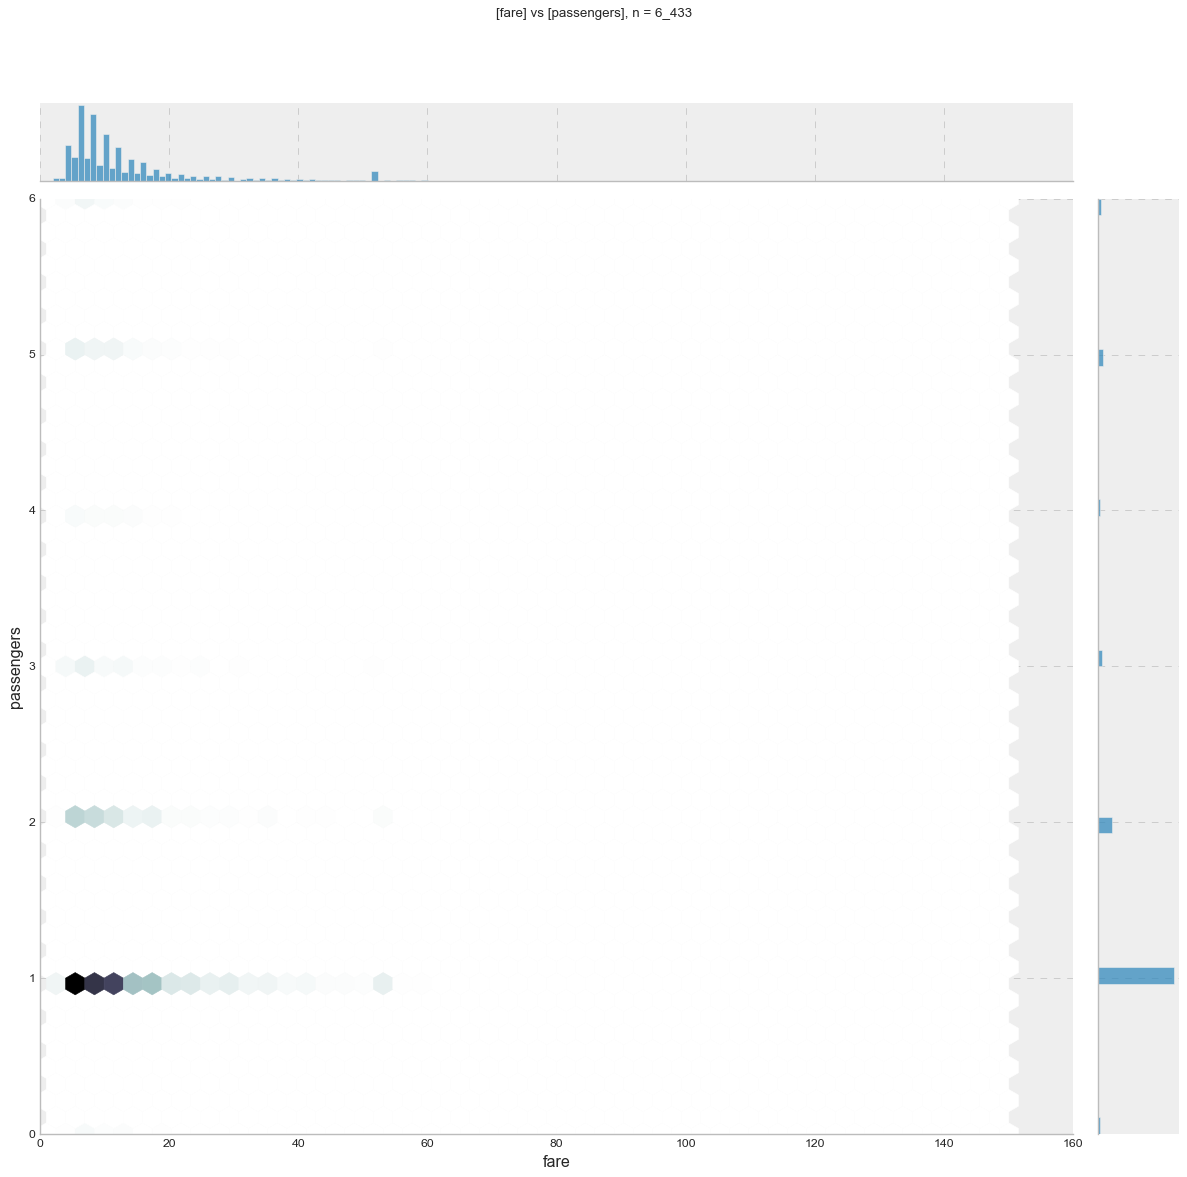

In [45]:
_df = df[["fare", "passengers"]]
# pls.plot_joint(_df, precision=0, size=15, kind="reg", caption="")
pls.plot_joint(_df, precision=0, size=15, kind="hex", png_path=Path(".local/box6.png"))
# pls.plot_joint(_df, precision=0, size=5, kind="kde",)
# pls.plot_joint(_df, precision=0, size=5, kind="hist",)

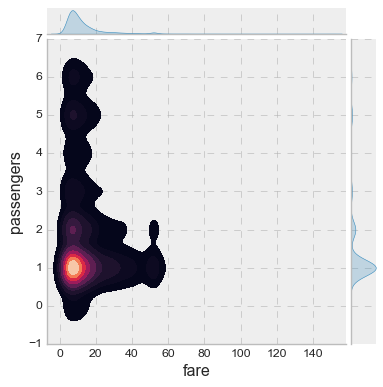

In [46]:
_df = df[["fare", "passengers"]]
# sb.set_theme(
#     rc={
#         "axes.facecolor": "lightgray",
#         "figure.facecolor": "cornflowerblue",
#     },
#     palette="tab10"
# )
# plt.style.use("dark_background")
# plt.style.use("dark_background")
# fig = 
sb.jointplot(
    x=_df.columns[0],
    y=_df.columns[1],
    data=_df,
    height=5,
    kind="kde",
    ratio=10,
    # marginal_ticks=True,
    # color='k',
    # palette="tab10",
    # color="black",
    fill=True,
    cmap="rocket",
    # style="bmh",
    # cmap="bone_r",
    title="lol"
)
# plt.show()

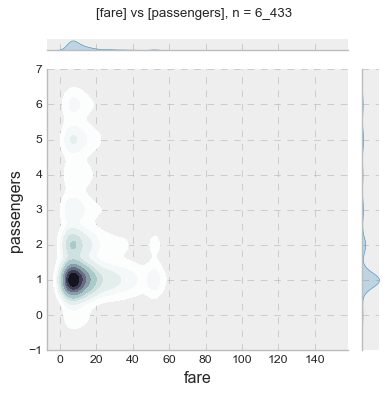

In [47]:
pls.plot_joint(_df, precision=0, size=5, kind="kde", png_path=Path(".local/box7.png"))

In [48]:
# sys.exit()

## barcode

In [49]:
from pandas_plots import hlp
url="https://github.com/robert-koch-institut/Bundesweiter_klinischer_Krebsregisterdatensatz-Datenschema_und_Klassifikationen"
# url="http://google.com"

# hlp.create_barcode_from_url(
#     url=url,
#     output_path=".local/zfkd-repo.png",
#     show_image=True,
# )

## misc

In [50]:
# df
# from pandas_plots import hlp
hlp.add_datetime_columns(df,"dropoff")
# df

⏳ Adding datetime columns basing off of: dropoff


,pickup,dropoff,passengers,distance,fare,tip,tolls,total,color,payment,...,dropoff_zone,pickup_borough,dropoff_borough,YYYY,MM,Q,YYYY-MM,YYYYQ,YYYY-WW,DDD
0,2019-03-23 20:21:09,2019-03-23 20:27:24,1,1.60,7.0,2.15,0.0,12.95,yellow,credit card,...,UN/Turtle Bay South,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W12,Sat
1,2019-03-04 16:11:55,2019-03-04 16:19:00,1,0.79,5.0,0.00,0.0,9.30,yellow,cash,...,Upper West Side South,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W10,Mon
2,2019-03-27 17:53:01,2019-03-27 18:00:25,1,1.37,7.5,2.36,0.0,14.16,yellow,credit card,...,West Village,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W13,Wed
3,2019-03-10 01:23:59,2019-03-10 01:49:51,1,7.70,27.0,6.15,0.0,36.95,yellow,credit card,...,Yorkville West,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W10,Sun
4,2019-03-30 13:27:42,2019-03-30 13:37:14,3,2.16,9.0,1.10,0.0,13.40,yellow,credit card,...,Yorkville West,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W13,Sat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6428,2019-03-31 09:51:53,2019-03-31 09:55:27,1,0.75,4.5,1.06,0.0,6.36,green,credit card,...,Central Harlem North,Manhattan,Manhattan,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6429,2019-03-31 17:38:00,2019-03-31 18:34:23,1,18.74,58.0,0.00,0.0,58.80,green,credit card,...,East Concourse/Concourse Village,Queens,Bronx,2019,3,1,2019-03,2019Q1,2019-W13,Sun
6430,2019-03-23 22:55:18,2019-03-23 23:14:25,1,4.14,16.0,0.00,0.0,17.30,green,cash,...,Bushwick North,Brooklyn,Brooklyn,2019,3,1,2019-03,2019Q1,2019-W12,Sat
6431,2019-03-04 10:09:25,2019-03-04 10:14:29,1,1.12,6.0,0.00,0.0,6.80,green,credit card,...,East Flatbush/Remsen Village,Brooklyn,Brooklyn,2019,3,1,2019-03,2019Q1,2019-W10,Mon


In [51]:
lol="""
The most important themes of the draft referendum are:
1. Improving the use of health data for research and innovation, particularly through the establishment of a National Data Access Point;
2. Enhancing the coordination and networking of different stakeholders involved in health data management;
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all areas of healthcare;
4. Providing better access to health data for patients and researchers, including through the development of a new law on health data protection;
5. Facilitating the exchange of health data between different countries and regions, particularly within the European Union (EU);
6. Ensuring that data are used in a way that promotes sustainable development and achieves the United Nations' Sustainable Development Goals (SDGs)."""

In [52]:
print(
hlp.wrap_text(
    text=lol,
    # max_items_in_line=40,
    use_sep=True,
    use_apo=True,
)
)

[The most important themes of the draft referendum are:  
1. Improving the use of health data for research and innovation particularly through  
the establishment of a National Data Access Point;  
2. Enhancing the coordination and networking of different stakeholders involved  
in health data management;  
3. Expanding the scope of the General Data Protection Regulation (GDPR) to cover all  
areas of healthcare;  
4. Providing better access to health data for patients and researchers including through  
the development of a new law on health data protection;  
5. Facilitating the exchange of health data between different countries and regions  
particularly within the European Union (EU);  
6. Ensuring that data are used in a way that promotes sustainable development and achieves  
the United Nations Sustainable Development Goals (SDGs).]
